In [1]:
from utils import *

#Task 1

##Part 2
The chosen model is ConvNet

In [2]:
from ptflops import get_model_complexity_info
import matplotlib.pyplot as plt
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class Args:
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

def train(net, trainloader, criterion, optimizer,device=device):
    net.train()
    net.to(device)
    #create args.device 
    args = Args()
    args.device = device
    progress_bar = tqdm(range(20), total=20, desc=f'Training - No data available', leave=True)

    for i in progress_bar:
        loss_avg, acc_avg, num_exp = 0, 0, 0
        for i_batch, datum in enumerate(trainloader):
            img = datum[0].float().to(args.device)
            lab = datum[1].long().to(args.device)
            n_b = lab.shape[0]
            output = net(img)
            loss = criterion(output, lab)
            acc = np.sum(np.equal(np.argmax(output.cpu().data.numpy(), axis=-1), lab.cpu().data.numpy()))
            loss_avg += loss.item()*n_b
            acc_avg += acc
            num_exp += n_b

            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_avg /= num_exp
        acc_avg /= num_exp
        progress_bar.set_description(f'Training - Loss: {loss_avg:.4f} - Accuracy: {acc_avg:.4f}')
    return net

def test(net, testloader, criterion, optimizer,device=device):
    net.eval()
    net.to(device)
    args = Args()
    args.device = device
    loss_avg, acc_avg, num_exp = 0, 0, 0
    for i_batch, datum in enumerate(testloader):
        img = datum[0].float().to(args.device)
        lab = datum[1].long().to(args.device)
        n_b = lab.shape[0]

        output = net(img)
        loss = criterion(output, lab)
        acc = np.sum(np.equal(np.argmax(output.cpu().data.numpy(), axis=-1), lab.cpu().data.numpy()))
        loss_avg += loss.item()*n_b
        acc_avg += acc
        num_exp += n_b


    loss_avg /= num_exp
    acc_avg /= num_exp
    print(f'Accuracy of the network on the test images: {acc_avg*100}%')

def count_flops(net, channel, im_size):
    param = (channel, im_size[0], im_size[1])
    flops, params = get_model_complexity_info(net, param, as_strings=True, print_per_layer_stat=False)
    print(f'FLOPs: {flops}')
    print(f'Params: {params}')

In [2]:
#MNIST Dataset
data_path = "./Project A/data"

#load the dataset
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader = get_dataset("MNIST", data_path)

#define the model
net = get_network('ConvNetD3', channel, num_classes, im_size)
net.to(device)

#define the loss function
criterion = nn.CrossEntropyLoss()
#define the optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
#define the learning rate scheduler
#train the model
#create trainloader
trainloader = torch.utils.data.DataLoader(dst_train, batch_size=64, shuffle=True)
net = train(net, trainloader, criterion, optimizer)

NameError: name 'get_dataset' is not defined

In [4]:
#test the model, report accuracy and FLOPs
#testloader = torch.utils.data.DataLoader(dst_test, batch_size=64, shuffle=False)
test(net, testloader, criterion, optimizer, device)
#report the FLOPs
count_flops(net, channel, im_size) 

Accuracy of the network on the test images: 99.4%
FLOPs: 49.59 MMac
Params: 317.71 k


In [3]:
#MHIST Dataset
#load the dataset
data_path = "mhist_dataset"
#print files in the directory
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader = get_dataset("MHIST", data_path)

#define the model
net = get_network('ConvNetD7', channel, num_classes, im_size)
net.to(device) 

#define the loss function
criterion = nn.CrossEntropyLoss()
#define the optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
#define the learning rate scheduler
#train the model
#create trainloader
trainloader = torch.utils.data.DataLoader(dst_train, batch_size=64, shuffle=True)
net=train(net, trainloader, criterion, optimizer)
            
            

Training - No data available:   0%|          | 0/20 [00:00<?, ?it/s]

Training - No data available:   0%|          | 0/20 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [6]:
#test the model, report accuracy and FLOPs
test(net, testloader, criterion, optimizer, "cpu")
#report the FLOPs
count_flops(net, channel, im_size) 

Accuracy of the network on the test images: 81.78096212896622%
FLOPs: 2.7 GMac
Params: 891.14 k


### Distillation function
Found here https://github.com/DataDistillation/DataDAM/blob/main/main_DataDAM.py

In [3]:
from DataDAM import DataDAM
import os
#MNIST Dataset
data_path = "./Project A/data"

#create a folder to save the synthetic dataset
if not os.path.exists(os.path.join(data_path, 'synthetic_dataset_MNIST_gaussian')):
    os.makedirs(os.path.join(data_path, 'synthetic_dataset_MNIST_gaussian'))

#load the dataset
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader = get_dataset("MNIST", data_path)

#define the model
net = 'ConvNetD3'

Distillator = DataDAM(net, dst_train, 10, num_classes=num_classes, im_size=im_size, channels=channel, 
                      save_path=os.path.join(data_path, 'synthetic_dataset_MNIST_gaussian'),
                      batch_size=32, K=100, T=10, eta_S = 0.1, zeta_S = 1, eta_theta = 0.01, zeta_theta=50, lambda_mmd=0.01, device="cpu", minibatches_size=256)

mean_gaussian = 0
std_gaussian = 1
#Distillator.initialize_synthetic_dataset_from_gaussian_noise(mean_gaussian,std_gaussian)
#Distillator.initialize_synthetic_dataset_from_real()

trainloader = torch.utils.data.DataLoader(dst_train, batch_size=64, shuffle=True)
condensed_dataset = Distillator.train("Gaussian", mean_gaussian, std_gaussian)




/Data/GRZ/ECE1512_2024F_ProjectRepo_Grzeczkowicz/Project A/DataDAM.py:66: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  label_syn = torch.tensor([np.ones(self.IPC)*i for i in range(self.num_classes)], dtype=torch.long, requires_grad=False, device=self.device).view(-1) # [0,0,0, 1,1,1, ..., 9,9,9]
Iteration 1/10 - Weight Initializations: 100%|██████████| 100/100 [02:21<00:00,  1.41s/it]


Loss:  279686.53125 out_loss:  222033.859375 mid_loss:  57652.69140625


Iteration 2/10 - Weight Initializations: 100%|██████████| 100/100 [02:20<00:00,  1.40s/it]


Loss:  60634.34375 out_loss:  50742.19140625 mid_loss:  9892.1640625


Iteration 3/10 - Weight Initializations: 100%|██████████| 100/100 [02:18<00:00,  1.39s/it]


Loss:  37830.4296875 out_loss:  32413.251953125 mid_loss:  5417.17578125


Iteration 4/10 - Weight Initializations: 100%|██████████| 100/100 [02:19<00:00,  1.39s/it]


Loss:  29620.5546875 out_loss:  25659.01953125 mid_loss:  3961.53759765625


Iteration 5/10 - Weight Initializations: 100%|██████████| 100/100 [02:19<00:00,  1.40s/it]


Loss:  24477.259765625 out_loss:  21402.677734375 mid_loss:  3074.5830078125


Iteration 6/10 - Weight Initializations: 100%|██████████| 100/100 [02:19<00:00,  1.40s/it]


Loss:  21669.23046875 out_loss:  18963.279296875 mid_loss:  2705.946044921875


Iteration 7/10 - Weight Initializations: 100%|██████████| 100/100 [02:19<00:00,  1.40s/it]


Loss:  19622.24609375 out_loss:  17341.873046875 mid_loss:  2280.369384765625


Iteration 8/10 - Weight Initializations: 100%|██████████| 100/100 [02:19<00:00,  1.39s/it]


Loss:  17871.564453125 out_loss:  15846.3203125 mid_loss:  2025.2454833984375


Iteration 9/10 - Weight Initializations: 100%|██████████| 100/100 [02:19<00:00,  1.40s/it]


Loss:  16082.755859375 out_loss:  14309.94921875 mid_loss:  1772.802490234375


Iteration 10/10 - Weight Initializations: 100%|██████████| 100/100 [02:22<00:00,  1.43s/it]


Loss:  15016.9033203125 out_loss:  13398.619140625 mid_loss:  1618.2813720703125


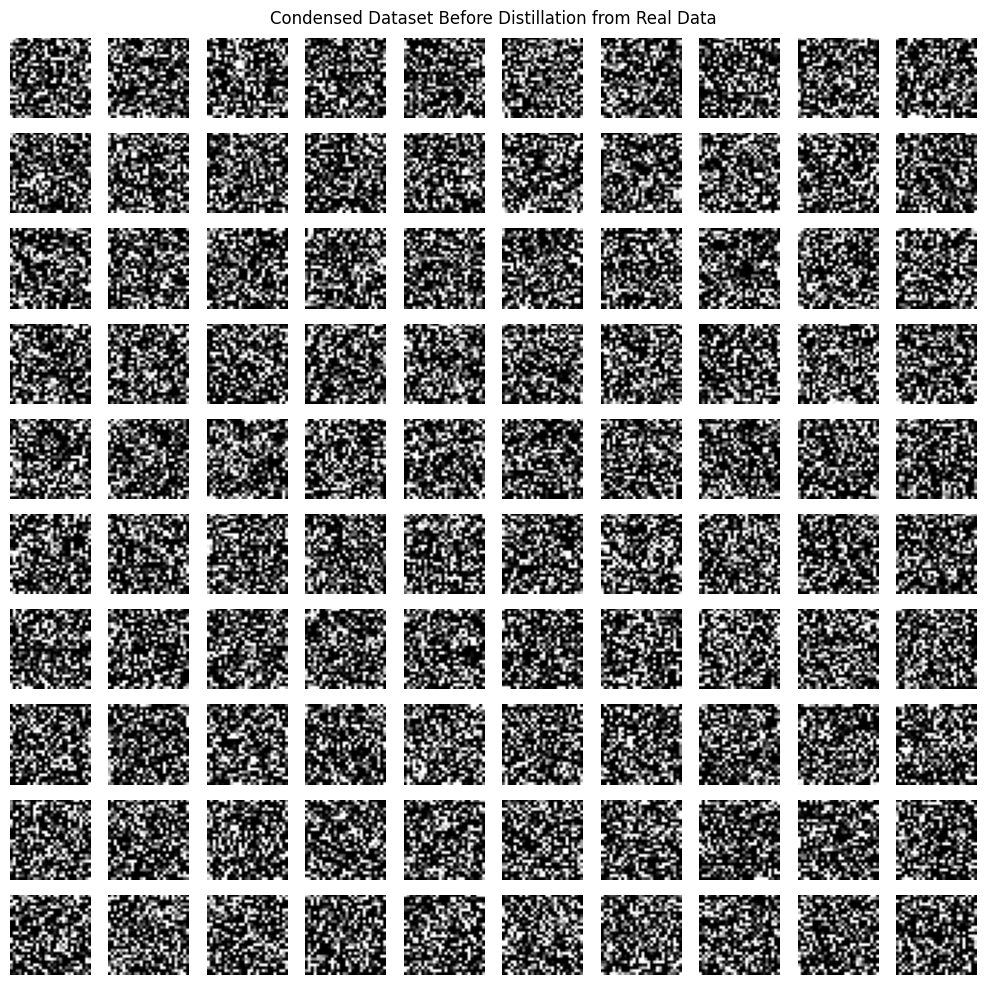

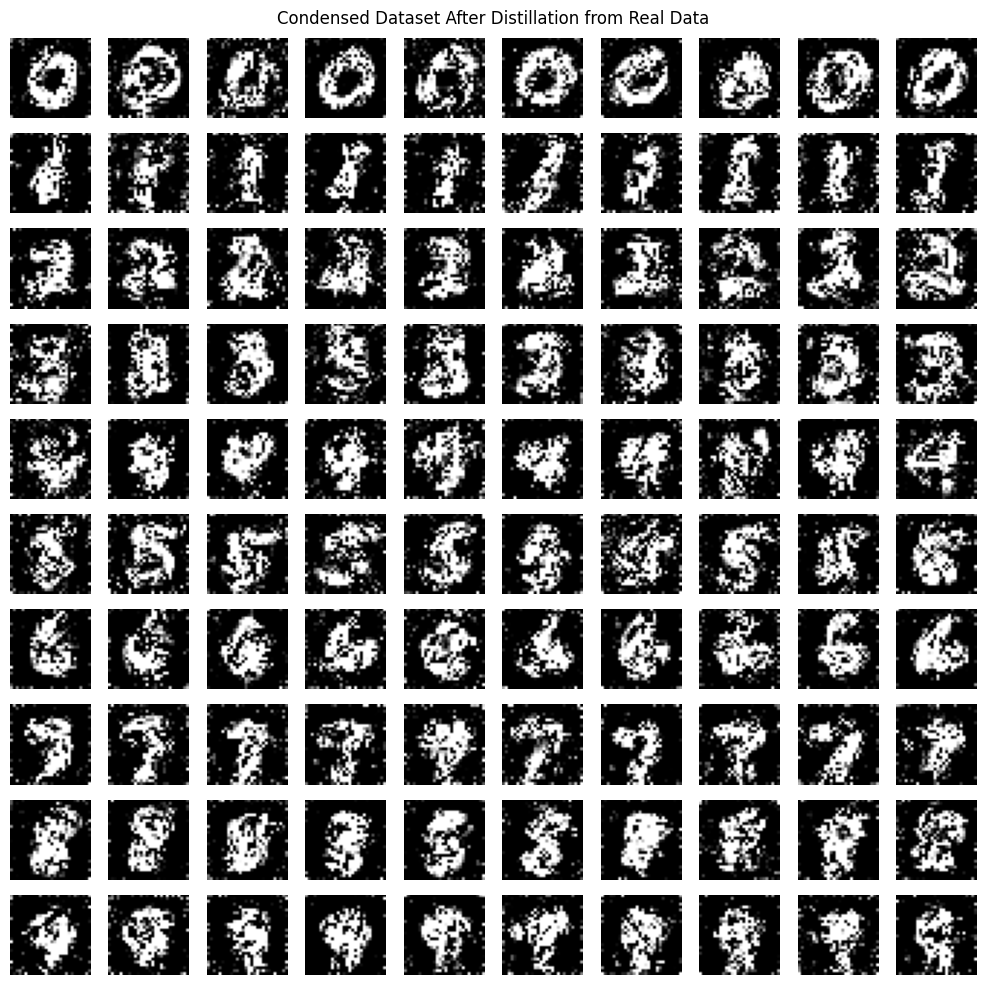

In [14]:
import matplotlib.pyplot as plt
for j in [0, 10]:
    # Create a figure with 10x10 subplots
    fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))
    
    # Load the images from the folder
    folder_path = os.path.join(data_path, 'synthetic_dataset_MNIST_gaussian', 'step_' + str(j))
    images = os.listdir(folder_path)
    

    for idx, image in enumerate(images):
        # Open the image
        img = Image.open(os.path.join(folder_path, image))
        
        # Get the row and column indices for the subplot (i.e., 10x10 grid)
        row = idx // 10
        col = idx % 10
        
        # Plot the image in the appropriate subplot
        ax[row, col].imshow(img, cmap='gray')
        ax[row, col].axis('off')  # Hide axis

    # Set the title based on whether it's before or after distillation
    if j == 0:
        fig.suptitle("Condensed Dataset Before Distillation from Gaussian Data")
    else:
        fig.suptitle("Condensed Dataset After Distillation from Gaussian Data")
    
    # Show the plot
    plt.tight_layout()
    plt.show()

In [15]:
from DataDAM import DataDAM
import os
#MNIST Dataset
data_path = "./Project A/data"

#create a folder to save the synthetic dataset
if not os.path.exists(os.path.join(data_path, 'synthetic_dataset_MNIST_real')):
    os.makedirs(os.path.join(data_path, 'synthetic_dataset_MNIST_real'))

#load the dataset
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader = get_dataset("MNIST", data_path)

#define the model
net = 'ConvNetD3'

Distillator = DataDAM(net, dst_train, 10, num_classes=num_classes, im_size=im_size, channels=channel, 
                      save_path=os.path.join(data_path, 'synthetic_dataset_MNIST_real'),
                      batch_size=32, K=100, T=10, eta_S = 0.1, zeta_S = 1, eta_theta = 0.01, zeta_theta=50, lambda_mmd=0.01, device="cpu", minibatches_size=256)
#Distillator.initialize_synthetic_dataset_from_gaussian_noise(mean_gaussian,std_gaussian)
#Distillator.initialize_synthetic_dataset_from_real()

trainloader = torch.utils.data.DataLoader(dst_train, batch_size=64, shuffle=True)
condensed_dataset = Distillator.train("Real")




Iteration 1/10 - Weight Initializations: 100%|██████████| 100/100 [02:19<00:00,  1.39s/it]


Loss:  12431.509765625 out_loss:  9352.818359375 mid_loss:  3078.696044921875


Iteration 2/10 - Weight Initializations: 100%|██████████| 100/100 [02:18<00:00,  1.39s/it]


Loss:  7719.751953125 out_loss:  6040.66064453125 mid_loss:  1679.089111328125


Iteration 3/10 - Weight Initializations: 100%|██████████| 100/100 [02:20<00:00,  1.40s/it]


Loss:  7796.9736328125 out_loss:  6197.9345703125 mid_loss:  1599.042236328125


Iteration 4/10 - Weight Initializations: 100%|██████████| 100/100 [02:19<00:00,  1.40s/it]


Loss:  12193.2041015625 out_loss:  10354.712890625 mid_loss:  1838.4942626953125


Iteration 5/10 - Weight Initializations: 100%|██████████| 100/100 [02:19<00:00,  1.39s/it]


Loss:  19674.24609375 out_loss:  16860.169921875 mid_loss:  2814.07568359375


Iteration 6/10 - Weight Initializations: 100%|██████████| 100/100 [02:19<00:00,  1.39s/it]


Loss:  21859.064453125 out_loss:  18973.810546875 mid_loss:  2885.26025390625


Iteration 7/10 - Weight Initializations: 100%|██████████| 100/100 [02:19<00:00,  1.39s/it]


Loss:  17528.404296875 out_loss:  15185.7685546875 mid_loss:  2342.641357421875


Iteration 8/10 - Weight Initializations: 100%|██████████| 100/100 [02:19<00:00,  1.39s/it]


Loss:  14271.98828125 out_loss:  12446.5048828125 mid_loss:  1825.4801025390625


Iteration 9/10 - Weight Initializations: 100%|██████████| 100/100 [02:19<00:00,  1.39s/it]


Loss:  11606.5126953125 out_loss:  10187.501953125 mid_loss:  1419.0087890625


Iteration 10/10 - Weight Initializations:  64%|██████▍   | 64/100 [01:30<00:52,  1.45s/it]

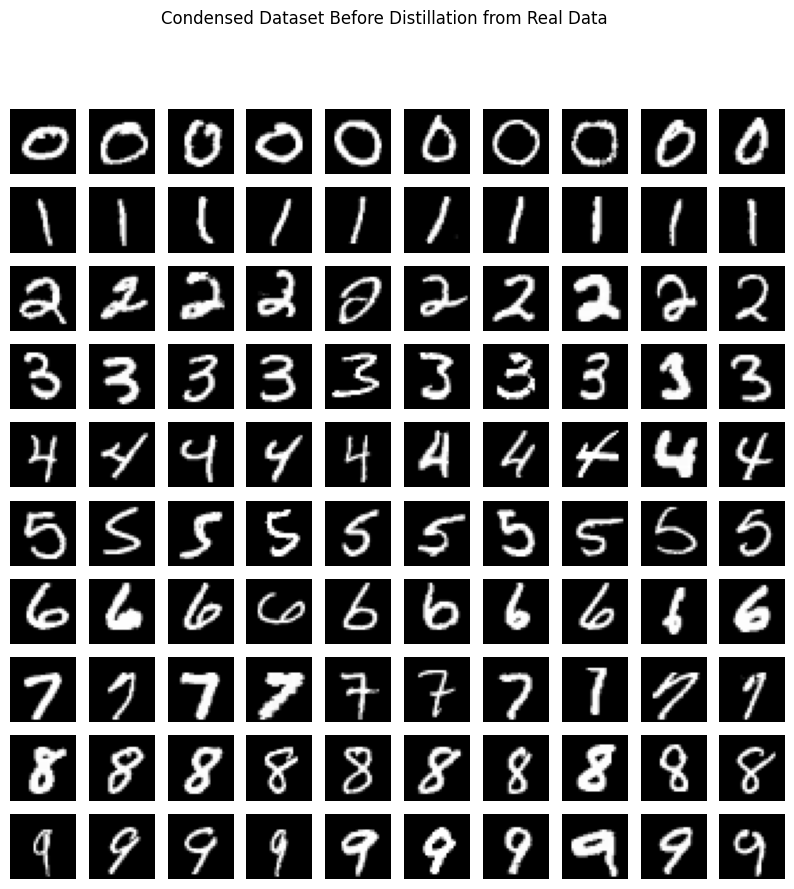

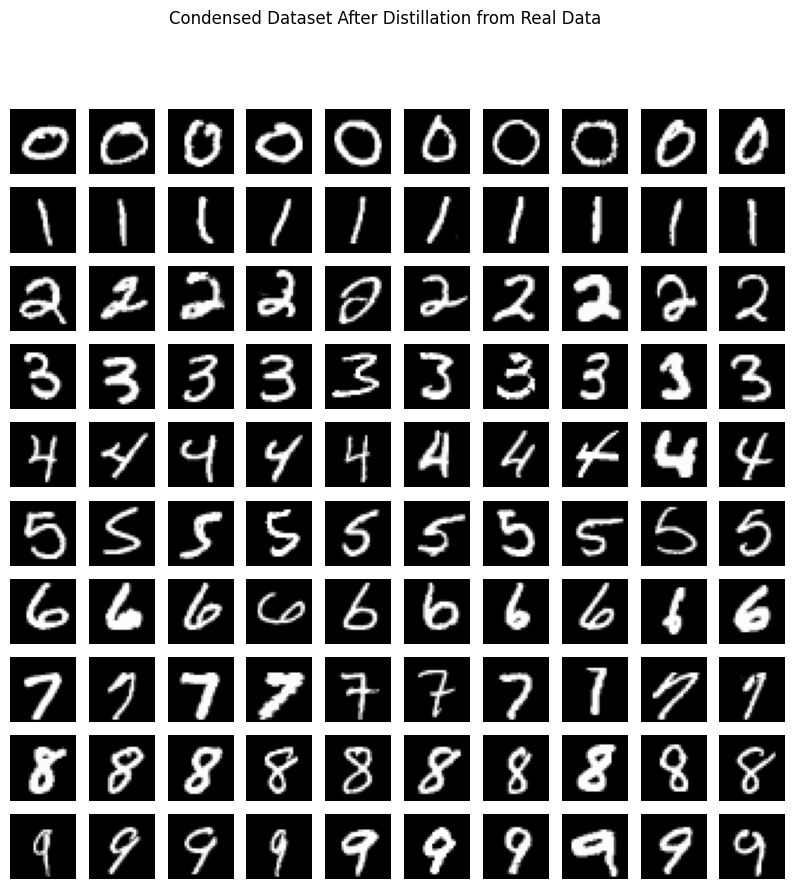

In [11]:
import matplotlib.pyplot as plt
for j in [0, 10]:
    # Create a figure with 10x10 subplots
    fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))
    
    # Load the images from the folder
    folder_path = os.path.join(data_path, 'synthetic_dataset_MNIST_real', 'step_' + str(j))
    images = os.listdir(folder_path)
    

    for idx, image in enumerate(images):
        # Open the image
        img = Image.open(os.path.join(folder_path, image))
        
        # Get the row and column indices for the subplot (i.e., 10x10 grid)
        row = idx // 10
        col = idx % 10
        
        # Plot the image in the appropriate subplot
        ax[row, col].imshow(img, cmap='gray')
        ax[row, col].axis('off')  # Hide axis

    # Set the title based on whether it's before or after distillation
    if j == 0:
        fig.suptitle("Condensed Dataset Before Distillation from Real Data")
    else:
        fig.suptitle("Condensed Dataset After Distillation from Real Data")
    
    # Show the plot
    plt.tight_layout()
    plt.show()

In [13]:
from DataDAM import DataDAM
import os
#MNIST Dataset
data_path = "./Project A/data"

#create a folder to save the synthetic dataset
if not os.path.exists(os.path.join(data_path, 'synthetic_dataset_MHIST_gaussian')):
    os.makedirs(os.path.join(data_path, 'synthetic_dataset_MHIST_gaussian'))

#load the dataset
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader = get_dataset("MHIST", data_path)

#define the model
net = 'ConvNetD7'

Distillator = DataDAM(net, dst_train, 10, num_classes=num_classes, im_size=im_size, channels=channel, 
                      save_path=os.path.join(data_path, 'synthetic_dataset_MHIST_gaussian'),
                      batch_size=32, K=100, T=10, eta_S = 0.1, zeta_S = 1, eta_theta = 0.01, zeta_theta=50, lambda_mmd=0.01, device="cpu", minibatches_size=256)

mean_gaussian = 0
std_gaussian = 1
#Distillator.initialize_synthetic_dataset_from_gaussian_noise(mean_gaussian,std_gaussian)
#Distillator.initialize_synthetic_dataset_from_real()

trainloader = torch.utils.data.DataLoader(dst_train, batch_size=64, shuffle=True)
condensed_dataset = Distillator.train("Gaussian", mean_gaussian, std_gaussian)




K:   0%|          | 0/200 [00:39<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
for j in [0, 10]:
    # Create a figure with 10x10 subplots
    fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))
    
    # Load the images from the folder
    folder_path = os.path.join(data_path, 'synthetic_dataset_MHIST_gaussian', 'step_' + str(j))
    images = os.listdir(folder_path)
    

    for idx, image in enumerate(images):
        # Open the image
        img = Image.open(os.path.join(folder_path, image))
        
        # Get the row and column indices for the subplot (i.e., 10x10 grid)
        row = idx // 10
        col = idx % 10
        
        # Plot the image in the appropriate subplot
        ax[row, col].imshow(img, cmap='gray')
        ax[row, col].axis('off')  # Hide axis

    # Set the title based on whether it's before or after distillation
    if j == 0:
        fig.suptitle("Condensed Dataset Before Distillation from Gaussian Data")
    else:
        fig.suptitle("Condensed Dataset After Distillation from Gaussian Data")
    
    # Show the plot
    plt.tight_layout()
    plt.show()

In [ ]:
from DataDAM import DataDAM
import os
#MNIST Dataset
data_path = "./Project A/data"

#create a folder to save the synthetic dataset
if not os.path.exists(os.path.join(data_path, 'synthetic_dataset_MHIST_real')):
    os.makedirs(os.path.join(data_path, 'synthetic_dataset_MHIST_real'))

#load the dataset
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader = get_dataset("MHIST", data_path)

#define the model
net = 'ConvNetD7'

Distillator = DataDAM(net, dst_train, 10, num_classes=num_classes, im_size=im_size, channels=channel, 
                      save_path=os.path.join(data_path, 'synthetic_dataset_MHIST_real'),
                      batch_size=32, K=100, T=10, eta_S = 0.1, zeta_S = 1, eta_theta = 0.01, zeta_theta=50, lambda_mmd=0.01, device="cpu", minibatches_size=256)

mean_gaussian = 0
std_gaussian = 1
#Distillator.initialize_synthetic_dataset_from_gaussian_noise(mean_gaussian,std_gaussian)
#Distillator.initialize_synthetic_dataset_from_real()

trainloader = torch.utils.data.DataLoader(dst_train, batch_size=64, shuffle=True)
condensed_dataset = Distillator.train("Real")




In [ ]:
import matplotlib.pyplot as plt
for j in [0, 10]:
    # Create a figure with 10x10 subplots
    fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))
    
    # Load the images from the folder
    folder_path = os.path.join(data_path, 'synthetic_dataset_MHIST_real', 'step_' + str(j))
    images = os.listdir(folder_path)
    

    for idx, image in enumerate(images):
        # Open the image
        img = Image.open(os.path.join(folder_path, image))
        
        # Get the row and column indices for the subplot (i.e., 10x10 grid)
        row = idx // 10
        col = idx % 10
        
        # Plot the image in the appropriate subplot
        ax[row, col].imshow(img, cmap='gray')
        ax[row, col].axis('off')  # Hide axis

    # Set the title based on whether it's before or after distillation
    if j == 0:
        fig.suptitle("Condensed Dataset Before Distillation from Real Data")
    else:
        fig.suptitle("Condensed Dataset After Distillation from Real Data")
    
    # Show the plot
    plt.tight_layout()
    plt.show()